<a href="https://colab.research.google.com/github/AyobamiMichael/CatAndDogImageClassifier/blob/main/Copy_of_fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2025-02-11 21:19:30--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   378MB/s    in 0.2s    

2025-02-11 21:19:31 (378 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import shutil

test_dir = test_dir
new_test_subdir = os.path.join(test_dir, "all")

if not os.path.exists(new_test_subdir):
    os.makedirs(new_test_subdir)

for filename in os.listdir(test_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        old_path = os.path.join(test_dir, filename)
        new_path = os.path.join(new_test_subdir, filename)
        shutil.move(old_path, new_path)



✅ All test images moved to 'test/all/' successfully!


In [44]:
# 3
train_image_generator =  ImageDataGenerator(rescale=1./255)
validation_image_generator =  ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Create generators
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,
    class_mode='binary'
)

validation_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,
    class_mode='binary'
)


test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,   # Batch size = 1 for inference
    class_mode=None, # No labels for test data
    shuffle=False  # Keep image order
)





Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


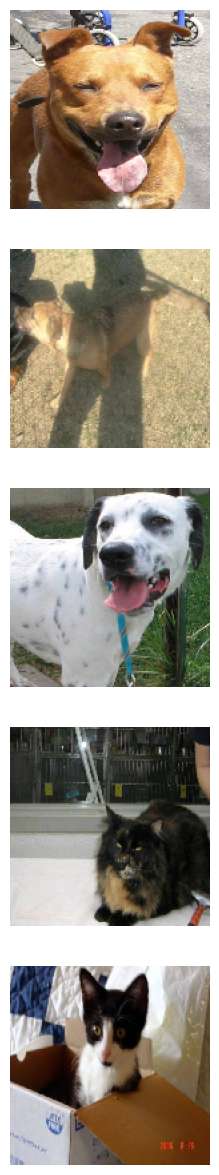

In [45]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [52]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)



Found 2000 images belonging to 2 classes.


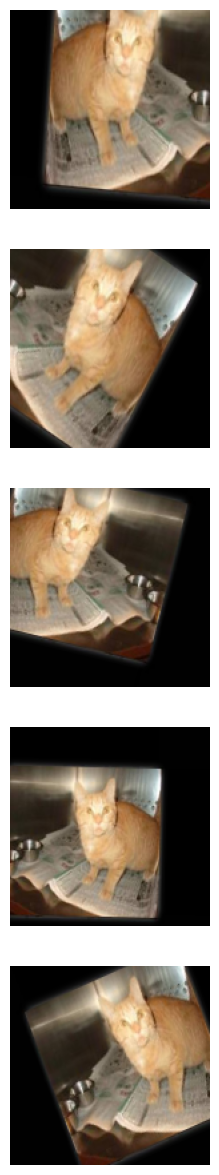

In [51]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [48]:
test_data_gen.reset()  # Reset iterator


In [49]:
# 7
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),  # Helps prevent overfitting
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
# 8
EPOCHS = 15

history = model.fit(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=EPOCHS,
    validation_data=validation_data_gen,
    validation_steps=len(validation_data_gen)
)


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5060 - loss: 0.8533 - val_accuracy: 0.6120 - val_loss: 0.6850
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 911ms/step - accuracy: 0.5314 - loss: 0.6832 - val_accuracy: 0.5040 - val_loss: 0.7022
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 904ms/step - accuracy: 0.5546 - loss: 0.6797 - val_accuracy: 0.5450 - val_loss: 0.6608
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 974ms/step - accuracy: 0.5822 - loss: 0.6630 - val_accuracy: 0.6390 - val_loss: 0.6213
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 934ms/step - accuracy: 0.5791 - loss: 0.6610 - val_accuracy: 0.6400 - val_loss: 0.6354
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 977ms/step - accuracy: 0.6269 - loss: 0.6423 - val_accuracy: 0.6480 - val_loss: 0.6211
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 981ms/step - accuracy: 0.6356 - loss: 0.6316 - val_accuracy: 0.6330 - val_loss: 0.6296
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 944ms/step - accuracy: 0.6255 - loss: 0.6332 - val_accurac

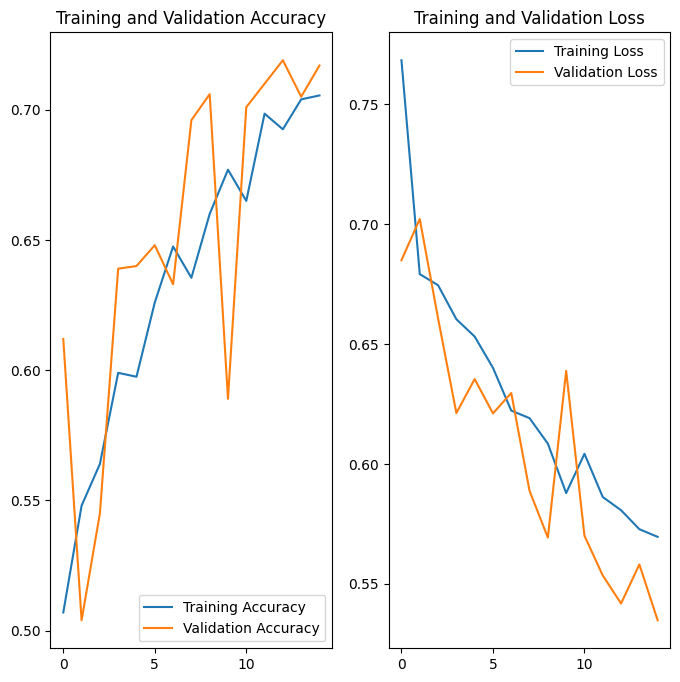

In [54]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


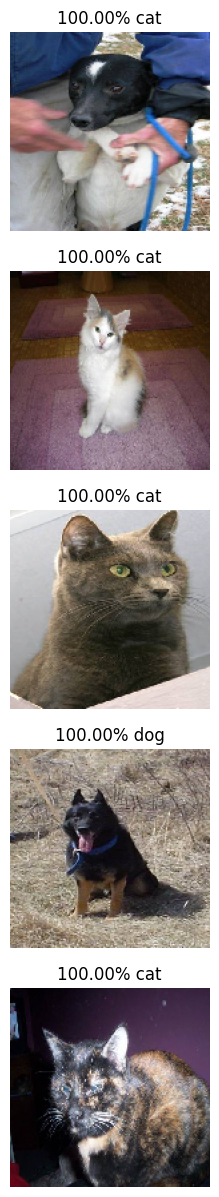

In [55]:
probabilities = model.predict(test_data_gen)
probabilities = [1 if prob > 0.5 else 0 for prob in probabilities]

# Plot test images with predictions
test_images = next(test_data_gen)
plotImages(test_images[:5], probabilities[:5])


In [56]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
